In [1]:
### importing qcomp ###
include("../src/qcomp.jl")
using .qcomp

using Yao
using YaoPlots
using LinearAlgebra
using PyPlot
using Random

In [2]:
# circ = build_QCNN(4)
# YaoPlots.plot(circ)

In [4]:
#Example use (random states vs uniform state)

seed = 2
Random.seed!(seed)

n = 4 # preferably a power of 2

states1 = [rand_state(n) for i=1:10]
states2 = [uniform_state(n) for i=1:10]
states = vcat([states1, states2]...)
labels = vcat([repeat([1],10), repeat([-1],10)]...)

test_states1 = [rand_state(n) for i=1:10]
test_states2 = [uniform_state(n) for i=1:10]
test_states = vcat([test_states1, test_states2]...)
test_labels = vcat([repeat([1],10), repeat([-1],10)]...);

d = Data(states, labels, test_states, test_labels)

In [5]:
iters = 300
lr = 0.05
sig = true

circ = build_QCNN(n)
p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ)
initialize_params(p);

In [6]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(states, labels, test_states, test_labels, p, iters, sig, lr; output=false)

Initial: loss = 2.646723338595912,tr_acc = 0.25, te_acc = 0.4
Final: loss = 0.006127189861477058,tr_acc = 1.0, te_acc = 0.8


([5.167475284950026, 6.114235739268996, 6.713254431069359, 0.0495287177201231, 4.2242361741873875, 3.3880783418285807, 3.3741993659285443, 1.1295687671064805, 3.695411238126671, 2.967673021552852, 5.3246284737730445, 0.26342541305349654], [2.646723338595912, 2.540307407349645, 2.4280658137362288, 2.327394660589006, 2.2539220163127385, 2.2045618608227073, 2.1682821421517633, 2.1394455873570575, 2.115397395260133, 2.094478714306469  …  0.006171292770831929, 0.006166100916789083, 0.006160983758327349, 0.006155940511332902, 0.006150970396533594, 0.006146072639428993, 0.006141246470225677, 0.006136491123777627, 0.006131805839531604, 0.006127189861477058], [0.25, 0.25, 0.25, 0.4, 0.4, 0.45, 0.45, 0.45, 0.5, 0.5  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.4, 0.4, 0.35, 0.35, 0.3, 0.3, 0.3, 0.25, 0.3, 0.3  …  0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], Any[0.8483689727319008, 0.963727529925609, 0.8851670783814609, 0.8842369111041124, 0.97666902831551, 0.9125514173531468, 0

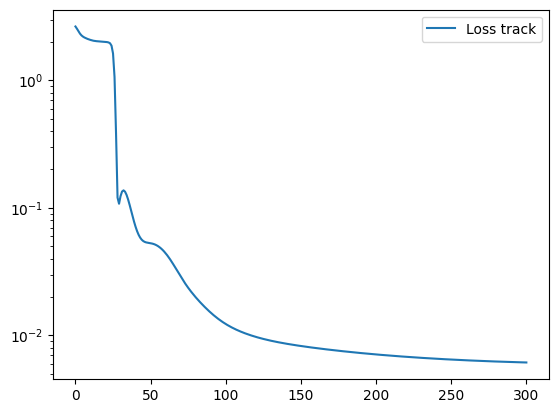

In [7]:
PyPlot.semilogy(0:iters, loss_track, label="Loss track")
PyPlot.legend()
PyPlot.display_figs()

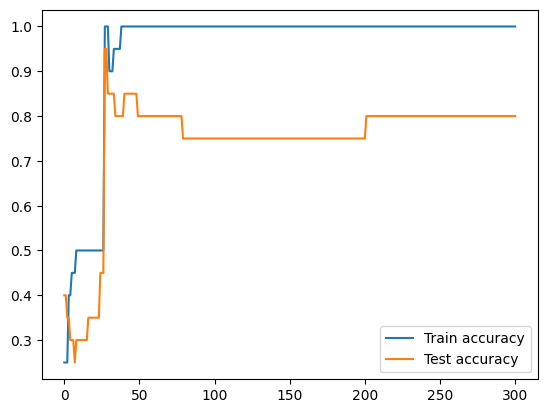

In [8]:
PyPlot.plot(0:iters, tr_track, label="Train accuracy")
PyPlot.plot(0:iters, te_track, label="Test accuracy")
PyPlot.legend()
PyPlot.display_figs()

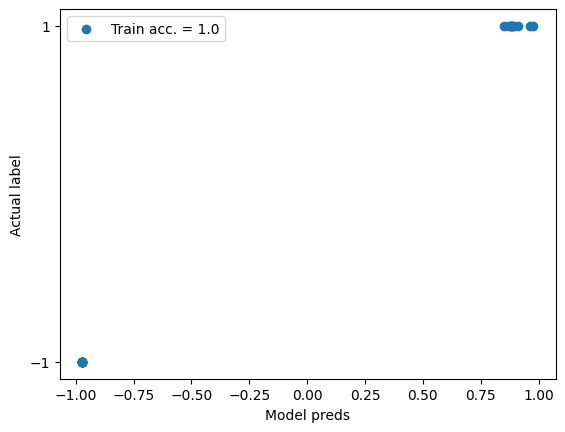

In [9]:
PyPlot.scatter(tr_preds, labels, label="Train acc. = $(round(tr_track[end],digits=2))")
#PyPlot.scatter(te_preds, test_labels, label="Test acc. = $(round(te_track[end],digits=2))")
PyPlot.xlabel("Model preds")
PyPlot.ylabel("Actual label")
PyPlot.yticks(-1:2:1)
PyPlot.legend()
PyPlot.display_figs()